In [1]:
# from statistics import median
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import nmrglue as ng


# import pulsee.simulation as sim
import pulsee.plot as vis

import tomography_helper_functions as helper
# from tomography.tomography_helper_functions import projection_fortunato, plot_spectra_together
# from tomography.tomography_helper_functions import index_to_element, integrate_simpson, integrate_optimized

# import * is bad practice, but this is the easiest way to do quick theoretical calculations with this many variables.
import operators as op
import global_constants as glob
from coeff_groups_class import CoefficientGroups

# commented out cuz it causes my computer to not plot anything:
#%matplotlib notebook

plt.rcParams['figure.dpi'] = glob.DPI_DISPLAY

# Importing Data
Rearranged folders (from Donny's usual format) so that both P1 and P2 files are in the same folder. This way I don't have to deal with separate "P1" and "P2" folders.

findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.


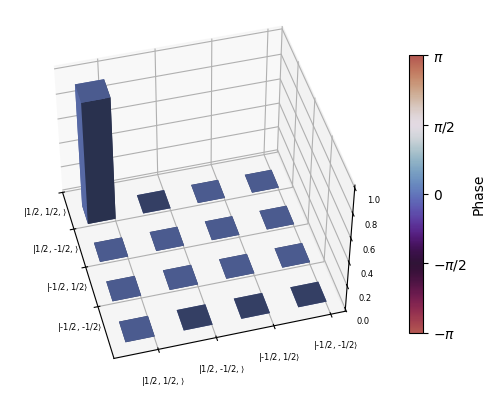

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.99999999 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]

In [2]:
state_name = "1000"
rho_theory = op.CLEAN_1000
vis.plot_complex_density_matrix(rho_theory)
display(rho_theory)

In [3]:
Bruker_folders_path = r"C:\Users\donny\Desktop\desktop_files\Brown\All_data\MIT\ADP_Sample_143-12_10_2024_with_decoupling"

In [4]:
folder_nums = os.listdir(f"{Bruker_folders_path}/{state_name}")
folder_nums = [str(s) for s in (sorted([int(x) for x in folder_nums]))] # ordering by increasing number value
folder_nums

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']

In [5]:
def get_folder_path(f_n):
    return f"{Bruker_folders_path}/{state_name}/{f_n}/pdata/1"

# all_components=True to get both the real & imaginary spectra
all_data = [ng.bruker.read_pdata(get_folder_path(fn), all_components=True)[1] for fn in folder_nums]
        
all_data = np.array(all_data)
all_data.shape

(14, 2, 32768)

In [6]:
all_raw_spectra = []
for real, imag in all_data:
    all_raw_spectra.append(real)
    all_raw_spectra.append(imag)
    
all_raw_spectra = np.array(all_raw_spectra)
all_raw_spectra.shape

(28, 32768)

Flip the frequency axis

In [7]:
all_spectra_unphased = np.flip(all_raw_spectra, axis=1)

# Calculating the frequency axis for the spectrum
All data in below cell is from Donny's email & Bruker plots

According to Bruker's software, the middle of the spectrum should be the experimental larmor frequency (with chemical shift included), and we can set this to 0 Hz. In other words, the frequency axis range is: (-spectrum_width/2, spectrum/2), with 0 in the middle, and left peak should occur at -$J$ and right peak at $J$

In [8]:
# DIFFERENT FOR THIS MEASUREMENT!
SPECTRUM_WIDTH = 2000 # Hz

freqs = np.linspace(-SPECTRUM_WIDTH / 2, SPECTRUM_WIDTH / 2, all_spectra_unphased.shape[1])

#B_0 = 14.0921*6/5  # Tesla
J = 22.22  # Hz
L_FREQ = -J / 2
R_FREQ = J / 2

# probably won't need...?
#SPECTRUM_OFFSET = 49697.66
#w_1_Bruker = 242950699.7  # Hz
#w_2_Bruker = 242951648.8  # Hz
#TEMP = 310  # Kelvin

# Doing a 90 degree global phase shift on our plots
Our receiver phase was set to -y, but our theory appears to set the receiver phase to +x
I also put a negative in front of the imaginary spectra because the relationship between the peak phases between the real & imaginary spectra does not line up with the standard theory (Levitt pg 103).
It appears that we need to multiply -1 to our imaginary spectra to agree with the theory. Seems a bit sketchy but works

In [9]:
complex_spectra = []
for i in range(0, len(all_spectra_unphased), 2):
    real = all_spectra_unphased[i]
    imag = all_spectra_unphased[i + 1]
    complex_spectra.append(real - 1j * imag)  # MULTIPLYING -1 TO IMAGINARY SPECTRA

complex_spectra = np.array(complex_spectra)
complex_spectra_transformed = complex_spectra * np.exp(1j * np.pi / 2)

all_spectra_transformed = []
for spectrum in complex_spectra_transformed:
    all_spectra_transformed.append(spectrum.real)
    all_spectra_transformed.append(spectrum.imag)

all_spectra = np.array(all_spectra_transformed)

# Plotting Everything Together

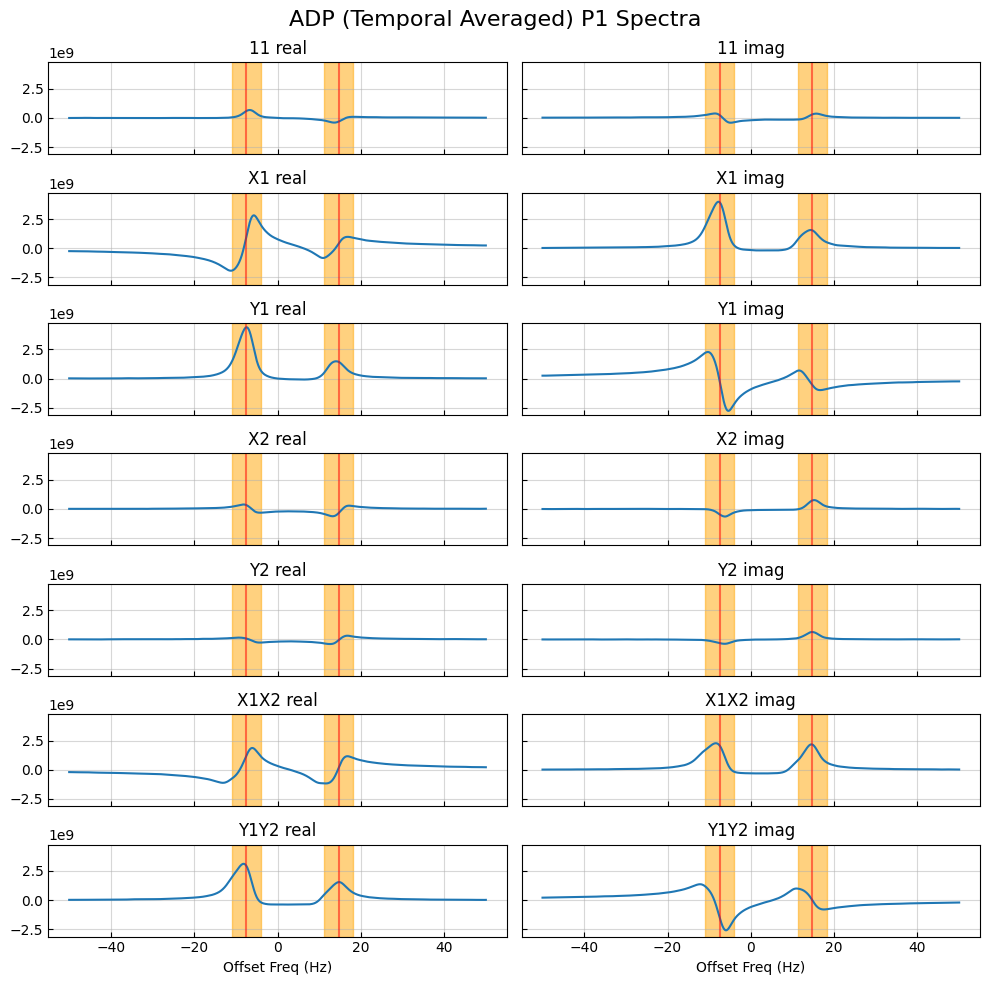

In [10]:
INT_WIDTH = 7  # in Hz. The width to integrate over.
X_LIMS_DISPLAY = [-50,50]


# Making an offset so the red lines visually line up with the peaks
p1_offset = 3.6
p1_freqs = (L_FREQ + p1_offset, R_FREQ + p1_offset)

fig_1, axs_1 = helper.plot_spectra_together(freqs, all_spectra[:all_spectra.shape[0]//2],
                                     glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p1_freqs[0], p1_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_1.suptitle('ADP (Temporal Averaged) P1 Spectra', size=16)
fig_1.tight_layout()
plt.show()

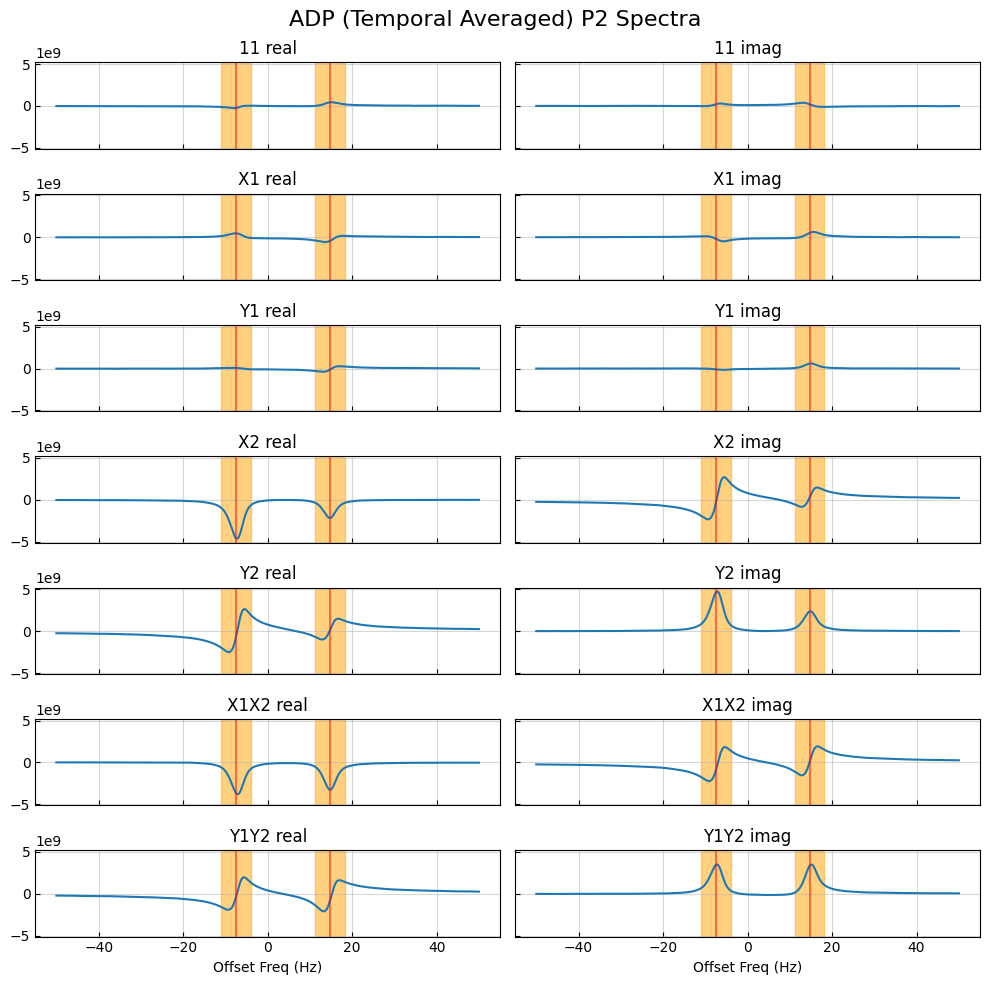

In [11]:
# Making an offset so the red lines visually line up with the peaks
p2_offset = 3.6
p2_freqs = (L_FREQ + p2_offset, R_FREQ + p2_offset)

fig_2, axs_2 = helper.plot_spectra_together(freqs, all_spectra[all_spectra.shape[0] // 2:], glob.SPECTRA_NAMES, X_LIMS_DISPLAY, p2_freqs[0], p2_freqs[1], int_width=INT_WIDTH, share_y=True)
fig_2.suptitle('ADP (Temporal Averaged) P2 Spectra', size=16)
fig_2.tight_layout()
plt.show()


# Preparing for Tomography Calculations:

We use convention of using the "I" to denote the first spin ($I_1$) and "S" the second spin ($I_2$)

$(I=I_1, S=I_2)$

Quick Check that our pulse sequences covers all 15 basis operators (not necessary)

In [12]:
op.check_basis_complete()

Operator basis is complete (15 elements)


## Eyeball Method
We first proceed with a 'eyeball' method to visually identify an important fact: our thermal density operator only has diagonal elements.

Furthermore, from theory we know that the only product operators with non-zero coefficients for temporal averaged state should be $I_z$, $S_z$, and $I_zS_z$.

For example, for our spectrum after no pulse (11), the sum of the peaks corresponds to the coefficient for the product operator $I_x$ and the difference corresponds to $I_xS_z$.
Thus, the sum of the peak intensities should be 0, and their differences should also be 0.

# Three Methods for calculating coefficients

1. Just the height of the spectrum at the expected peak locations
2. Integration of peaks (simpson method & trapezoid method, but both seem to give almost identical answers)
3. (no longer used) Fitting a theoretical Lorentzian model to our data using scipy.curve_fit

## First approach: get height of one data point closest to theoretical peak locations

### Construct a "`coefficient groups`". 
"coefficient groups" is a list of "group"s, with each group being a list of:

`[operator, (c1, spectrum type), (c2, spectrum type), (c3, spectrum type), ...]`

where the first element of the group is a product operator,

and the following elements are tuples of: (coefficients corresponding to that operator, the type of spectrum which the coefficient came from).

In the case of ADP there are two spectrum types: P1 and P2

(each spectrum produces two coefficients)

In [13]:
coeff_groups_height = CoefficientGroups()

for (i, spectrum) in enumerate(all_spectra):
    # Height of the point closest to each peak's frequency location
    L = spectrum[np.absolute(freqs - L_FREQ).argmin()]
    R = spectrum[np.absolute(freqs - R_FREQ).argmin()]
    coeff_groups_height.add_coefficient(op.product_operators[i][0], L + R, helper.index_to_element(i))
    coeff_groups_height.add_coefficient(op.product_operators[i][1], L - R, helper.index_to_element(i))
    # print(f"Spectrum {thermal_col_names[i]} L+R is: {(L+R):.1e}, L-R is {(L-R):.1e}")

print(f'number of groups is: {len(coeff_groups_height.data)} (<- should be 15)')

number of groups is: 15 (<- should be 15)


Average the coefficients for each operator, and reconstruct the density matrix

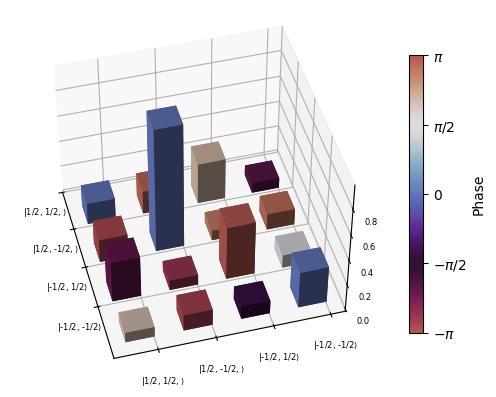

projection: 0.4099821960320687


In [14]:
rho_height = coeff_groups_height.reconstruct_rho(abs_trace=True)
vis.plot_complex_density_matrix(rho_height)
print(f"projection: {qt.fidelity(rho_height, rho_theory)}")

## Second Approach: integrate the raw data
1. Integrate sample points using (`scipy.integrate.trapezoid`)
2. Integrate sample points using (`scipy.integrate.simpson`)

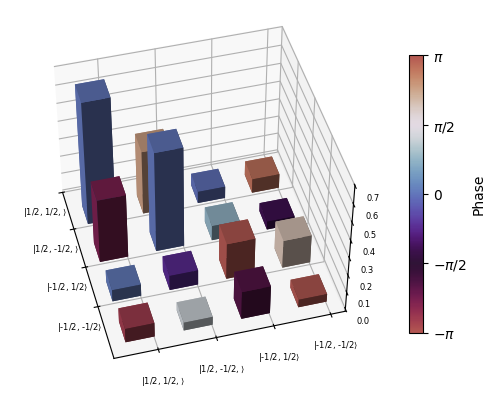

projection of naive integration: 0.8293561012578602


In [15]:
rho_naive = helper.integrate_simpson(freqs, all_spectra, p1_freqs, p2_freqs, INT_WIDTH)

vis.plot_complex_density_matrix(rho_naive)
print(f"projection of naive integration: {qt.fidelity(rho_naive, rho_theory)}")

### Integrating with various different parameters to find the integration with the largest projection value:

In [16]:
result_filename = f"result_{state_name}"
try:
    with open(result_filename, "rb") as result_file:
        best_rho_simpson, best_projection, best_offsets, best_int_width = pickle.load(result_file)
    print("Found previously saved result!")
        
except FileNotFoundError:
    print("Couldn't find saved result. Integrating and saving the result...")
    best_rho_simpson, best_projection, best_offsets, best_int_width = \
        helper.integrate_optimized(freqs, all_spectra, p1_freqs, p2_freqs, rho_theory)
    with open(result_filename, "wb") as result_file:
        pickle.dump([best_rho_simpson, best_projection, best_offsets, best_int_width], result_file)

Found previously saved result!


Best parameters: (0, 3), 1
Best projection: 0.9193594943713462


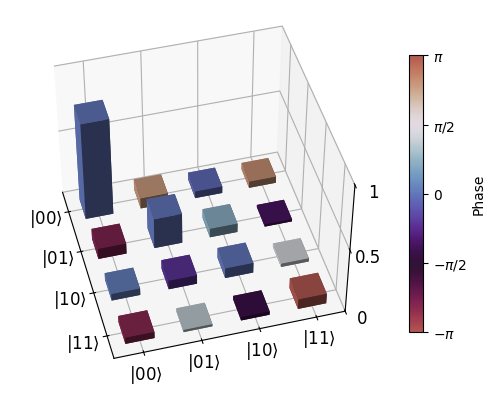

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

In [17]:
print(f"Best parameters: {best_offsets}, {best_int_width}")
print(f"Best projection: {best_projection}")
vis.plot_complex_density_matrix(best_rho_simpson, label_size=12, label_qubit=True, save_to="")

In [18]:
print(qt.fidelity(rho_theory, best_rho_simpson))
print(qt.fidelity(best_rho_simpson, rho_theory))
print(helper.projection_fortunato(rho_theory, best_rho_simpson))

0.8722652642055532
0.8722652656765194
(0.9193594943713462+0j)
